In [10]:
import numpy as np
import pandas as pd
# plotting
import matplotlib.pyplot as plt
import seaborn as sns
# custom packages
from Dissertation import RandomGenerator, convert_to_int, get_order_index
from utils import *
from estimators import ClusteredSegmentation
# scipy
import scipy
from scipy.sparse import vstack, identity, csr_array, vstack, csc_matrix
from scipy.sparse.linalg import svds, inv
from scipy.stats import f, ncf
# sklearn
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
# others
from tqdm.notebook import trange
from itertools import combinations, starmap
from functools import partial

In [11]:
rg = RandomGenerator(10, 20_000, order_by = 'var', use_dask = False, verbose= False)
X = rg._X.loc[:,rg._X.columns.str.contains('X')].apply(convert_to_int, axis = 1).to_numpy().reshape(-1,1)
y = rg()['y'].to_numpy().reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =  .20)
cluster = ClusteredSegmentation(n_clusters = 10)
cluster.fit(X, y)
tau = cluster.tau_metric
y_pred_exist = []
y_test_exist = []
for i, x in enumerate(X_test.reshape(-1)):
    try:
        y_pred_exist.append(cluster.predict(x))
        y_test_exist.append(y_test[i][0])
    except:
        pass
test_r2 = r2_score(y_test_exist, y_pred = y_pred_exist)

In [12]:
tau.r_sqf, tau.r_sqr, test_r2, tau.tau_est, tau.tau_LB

(0.8246105585356078,
 0.8006171038269879,
 0.800706707979843,
 0.13680102124899632,
 0.07146435312959541)

In [13]:
rg.config.parameter_size

175

### Barcode Scanner

In [14]:
class barcodeScanner:
    def __init__(self, estimator, config):
        self.config = config
        self.barcode_length = config.p
        if hasattr(estimator, "full_to_reduced"):
            self.segmentation_table = estimator.full_to_reduced.reset_index()
            self.num_clusters = estimator.n_clusters
            self.num_parameters_full = self.segmentation_table.shape[0]
            self.num_missing_pairs = 2**self.barcode_length - self.segmentation_table.shape[0]
            self.missing_pairs_decimal_repr = list(filter(lambda x: x not in self.segmentation_table.full, range(2**self.barcode_length)))
        else:
            raise AttributeError("'estimator' must have been fit and have 'full_to_reduced' attribute")
        self.var_names = [f"X_{i}" for i in range(self.barcode_length)]
        self.var_names_all = expand_var_names(self.var_names)
        
    def MLEscan(self):
        B = vstack([self.raw_contrast, scanner.missingPairsMLE()])
        proj = B.T @ inv(B @ B.T) @ B
    
    
    
    @property
    def raw_contrast(self):
        if hasattr(self, "raw_contrast_"):
            pass
        else:
            result = []
            for key in self.groupby_expanded_barcode.keys():
                result.append(self.gen_contrast(self.groupby_expanded_barcode[key]))
            self.raw_contrast_ = vstack(result)
            del result
        return self.raw_contrast_

    @staticmethod
    def gen_contrast(csc_matrix: scipy.sparse._csc.csc_matrix)-> scipy.sparse._csc.csc_matrix:
        fixed_array = csc_matrix.getrow(0)
        result = []
        for i in range(1, csc_matrix.shape[0]):
            result.append(fixed_array - csc_matrix.getrow(i))
        if len(result) > 0:
            return vstack(result)
        else:
            return None
    

    @property
    def groupby_expanded_barcode(self):
        if hasattr(self, "groupby_expanded_barcode_"):
            pass
        else:
            self.groupby_expanded_barcode_ = self.segmentation_table.groupby('reduced')['full'].apply(self.num_to_expanded_barcode_batch).to_dict()
        return self.groupby_expanded_barcode_
    
    def num_to_expanded_barcode_batch(self, seq):
        func = partial(self.num_to_barcode, length = self.barcode_length) # using self.num_to_barcode with the barcode_length
        result = []
        for num in seq:
            result.append(func(num))
        barcode_csc = vstack(result)
        del result
        result = []
        for barcode_array in barcode_csc:
            result.append(self.expand_barcode(barcode_array))
        return vstack(result)

    @staticmethod
    def num_to_barcode(i:int, length:int):
        binary = bin(i)[2:]
        while len(binary) < length:
            binary = '0' + binary
        return csc_matrix([int(x) for x in list(binary)], dtype = np.byte)
    
    def expand_barcode(self, barcode):
        ones_index_main = [f'X_{i}' for i in barcode.nonzero()[1]]
        ones_index = ones_index_main.copy()
        n = len(ones_index_main)+1
        for i in range(2, n):
            m = starmap(sum_string, combinations(ones_index_main, i))
            ones_index = ones_index + list(m)
        col = np.array([self.var_names_all.index(index)+1 for index in ones_index])
        col = np.insert(col, 0, 0)
        row = np.zeros((len(col),), dtype = np.byte)
        data = np.ones((len(col),), dtype = np.byte)
        csr_result = csr_array((data, (row, col)), shape=(1, 2**self.barcode_length))
        return csc_matrix(csr_result, dtype = np.byte)
    
    def missingPairsMLE(self):
        if self.num_missing_pairs > 0:  
            self.null_space_size = 2**self.barcode_length - self.num_clusters
            missing_pairs_expanded = self.num_to_expanded_barcode_batch(self.missing_pairs_decimal_repr)
            result = []
            for array in missing_pairs_expanded:
                max_index = array.nonzero()[1].max()
                col = np.array([max_index])
                row = np.zeros((1,), dtype = np.byte)
                data = np.ones((1,), dtype = np.byte)
                result.append(csc_matrix((data, (row, col)), shape=(1, 2**self.barcode_length)))
            return vstack(result)
        else:
            return None

In [17]:
scanner = barcodeScanner(estimator = cluster, config = rg.config)
scanner.raw_contrast, scanner.missingPairsMLE()

(<990x1024 sparse matrix of type '<class 'numpy.int8'>'
 	with 59610 stored elements in Compressed Sparse Row format>,
 <24x1024 sparse matrix of type '<class 'numpy.int8'>'
 	with 24 stored elements in Compressed Sparse Column format>)

Concatenating `raw_contrast` and `missingPairsMLE`, we then will have composite contrasts where each corresponding null hypothesis, $H_0: c_i^T \beta = 0$, i = 1, 2, ..., 1014, is not rejected by the model.

In [18]:
contrasts = vstack([scanner.raw_contrast, scanner.missingPairsMLE()])
C_proj = contrasts.T @ inv(contrasts @ contrasts.T) @ contrasts
output = []
for i in range(contrasts.shape[0]):
    output.append(contrasts.getrow(i)/np.sqrt(contrasts.getrow(i).count_nonzero()))
norm_contrasts = vstack(output)
del output
NC_proj = norm_contrasts.T @ norm_contrasts

/Users/gradcheckout/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/Users/gradcheckout/opt/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:239: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


### Experiment 1

With the MLE principle when handling missing pairs, we have stacked the 1024-10 = 1023 contrasts whose hypothesis tests aren't statistically significant based on the cluster model. The first experiement will actaully demonstrate how bad the projection matrix with the contrasts would be when finding ineffective $\beta$ for interaction effects in the model.

In [19]:
identity_csc = identity(2**10) # defining identity matrix

In [20]:
VI = (identity_csc - C_proj).T @ (identity_csc - C_proj)

In [21]:
from scipy.spatial.distance import mahalanobis, euclidean

In [22]:
C_distance = []
for i in range(2**10):
    dist = mahalanobis(identity_csc.getcol(i).toarray().reshape(-1),np.zeros(2**10), VI.toarray())
    C_distance.append(dist)
    del dist

In [23]:
index_list = scanner.var_names_all
index_list = ['intercept'] + index_list
y_true = []
for var_name in index_list:
    try: 
        rg.config.coefficients[var_name]
        y_true.append("Included")
    except:
        y_true.append("Not Included")

In [24]:
df = pd.DataFrame(zip(y_true, C_distance, np.random.rand(2**10)), columns = ['y_true','C_distance','random'])

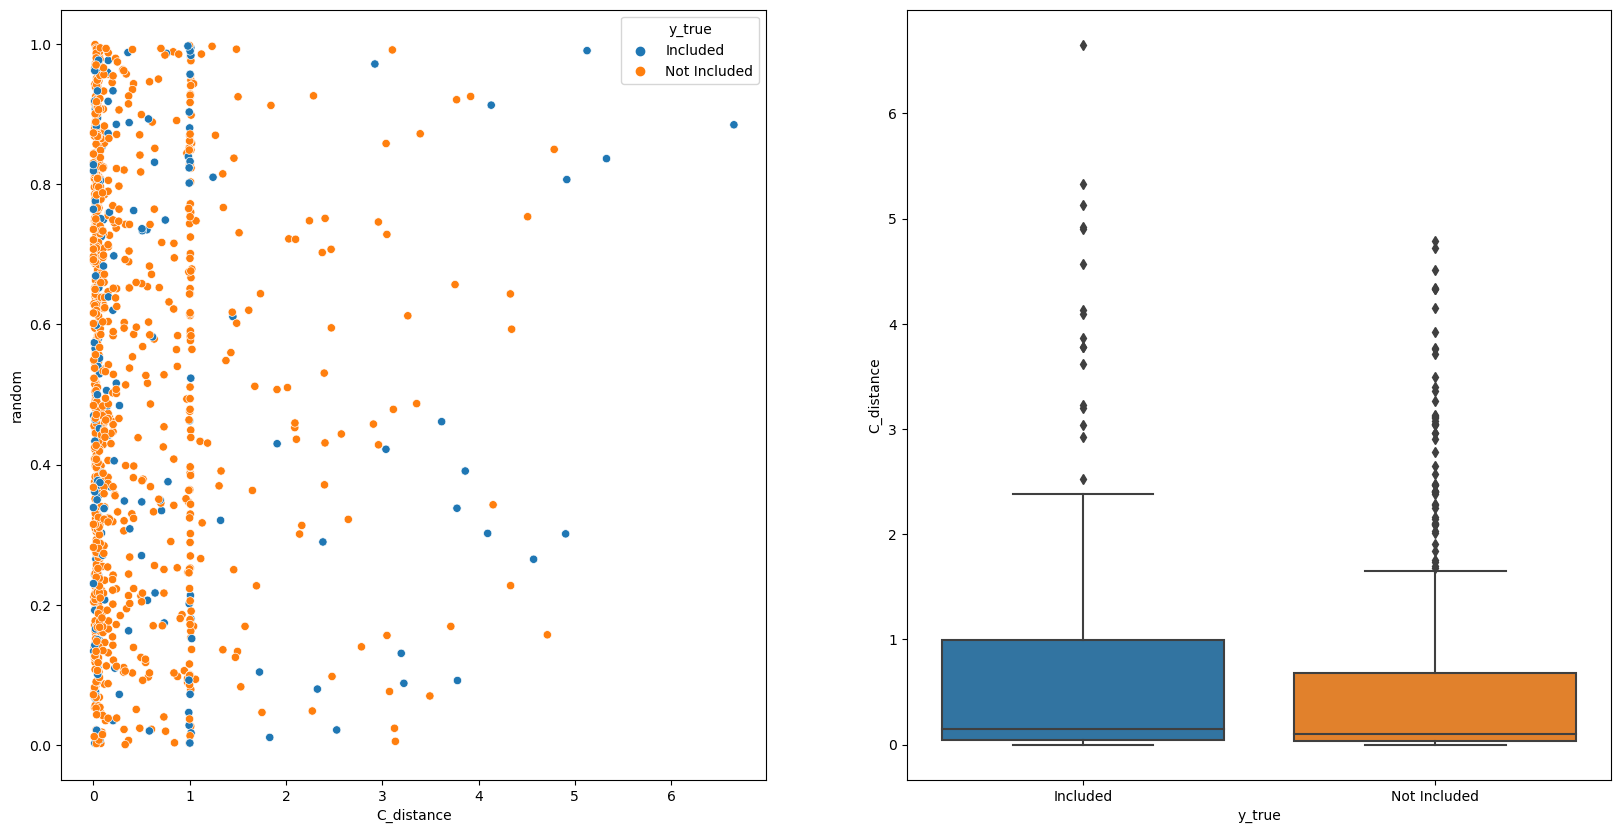

In [25]:
fig, ax = plt.subplots(1, 2, figsize = (20, 10))
sns.scatterplot(data = df, x = 'C_distance', y = 'random', hue = 'y_true', ax = ax[0])
sns.boxplot(data = df, x = 'y_true', y = 'C_distance', ax = ax[1])
plt.show()

In [27]:
scanner.num_missing_pairs # number of missing pairs

24

In [26]:
df.loc[df.C_distance < .001, :].groupby('y_true')['C_distance'].describe()

,count,mean,std,min,25%,50%,75%,max
y_true,,,,,,,,
Included,5.0,0.00007,0.000086,0.000000,0.000035,0.000037,0.000061,0.00022
Not Included,15.0,0.00006,0.000028,0.000026,0.000037,0.000056,0.000072,0.00012


Recall that we had 53 missing pairs, and by the MLE principles, the highest interaction implied by those missing pairs are included in the `contrasts` and you see that the number of unit vectors, $e_i$, that perfectly in the Image(i.e. row space) of `contrasts` aren't 24. If so, we should see the count of the y_true equals '*Not Included*' should be greater than 24.   

So what exactly happened? What we are essentially interested is how close each unit vector is to the linear space formed by each contrast. Then, we can say we are interested in $\frac{c}{c^T\cdot c}c^T \cdot e_i$ for all $c \in C$ Therefore, we came up with the projection matrix, $C (C^T C)^{-1} C^T$ but without orthogonal C, $(C^T C)^{-1}$ is not diagonal matrix, which is likely to mar our objective. Hence, we rather normalize each c by divide them by square root of count of non-zero, which is denoted by $C_{norm}$. And instead of a regular projection matrix, we drop out the inverse part of the formula, therefore, the matrix $e_i^T \cdot (I - C_{norm} \cdot C_{norm})^T \cdot (I - C_{norm} \cdot C_{norm}) \cdot e_i $, will measure the sum of distance between the unit vecot, $e_i$, and each normalized vector, $c_{norm}$. 

In [28]:
IV = (identity_csc - NC_proj).T @ (identity_csc - NC_proj)

In [29]:
distance = []
for i in range(2**10):
    dist = mahalanobis(identity_csc.getcol(i).toarray().reshape(-1),np.zeros(2**10), IV.toarray())
    distance.append(dist)
    del dist

In [30]:
df = pd.DataFrame(zip(y_true, C_distance, distance, np.random.rand(2**10)), columns = ['y_true','C_distance','NC_distance','random'])
df['missing'] = False
df.loc[scanner.missing_pairs_decimal_repr,'missing'] = True

In [31]:
df.groupby(['missing','y_true'])['y_true'].count()

missing  y_true      
False    Included        167
         Not Included    833
True     Included          8
         Not Included     16
Name: y_true, dtype: int64

From the frequency table above, we should expect 4 interaction effects would automatically misclassify because their pairs were missing.

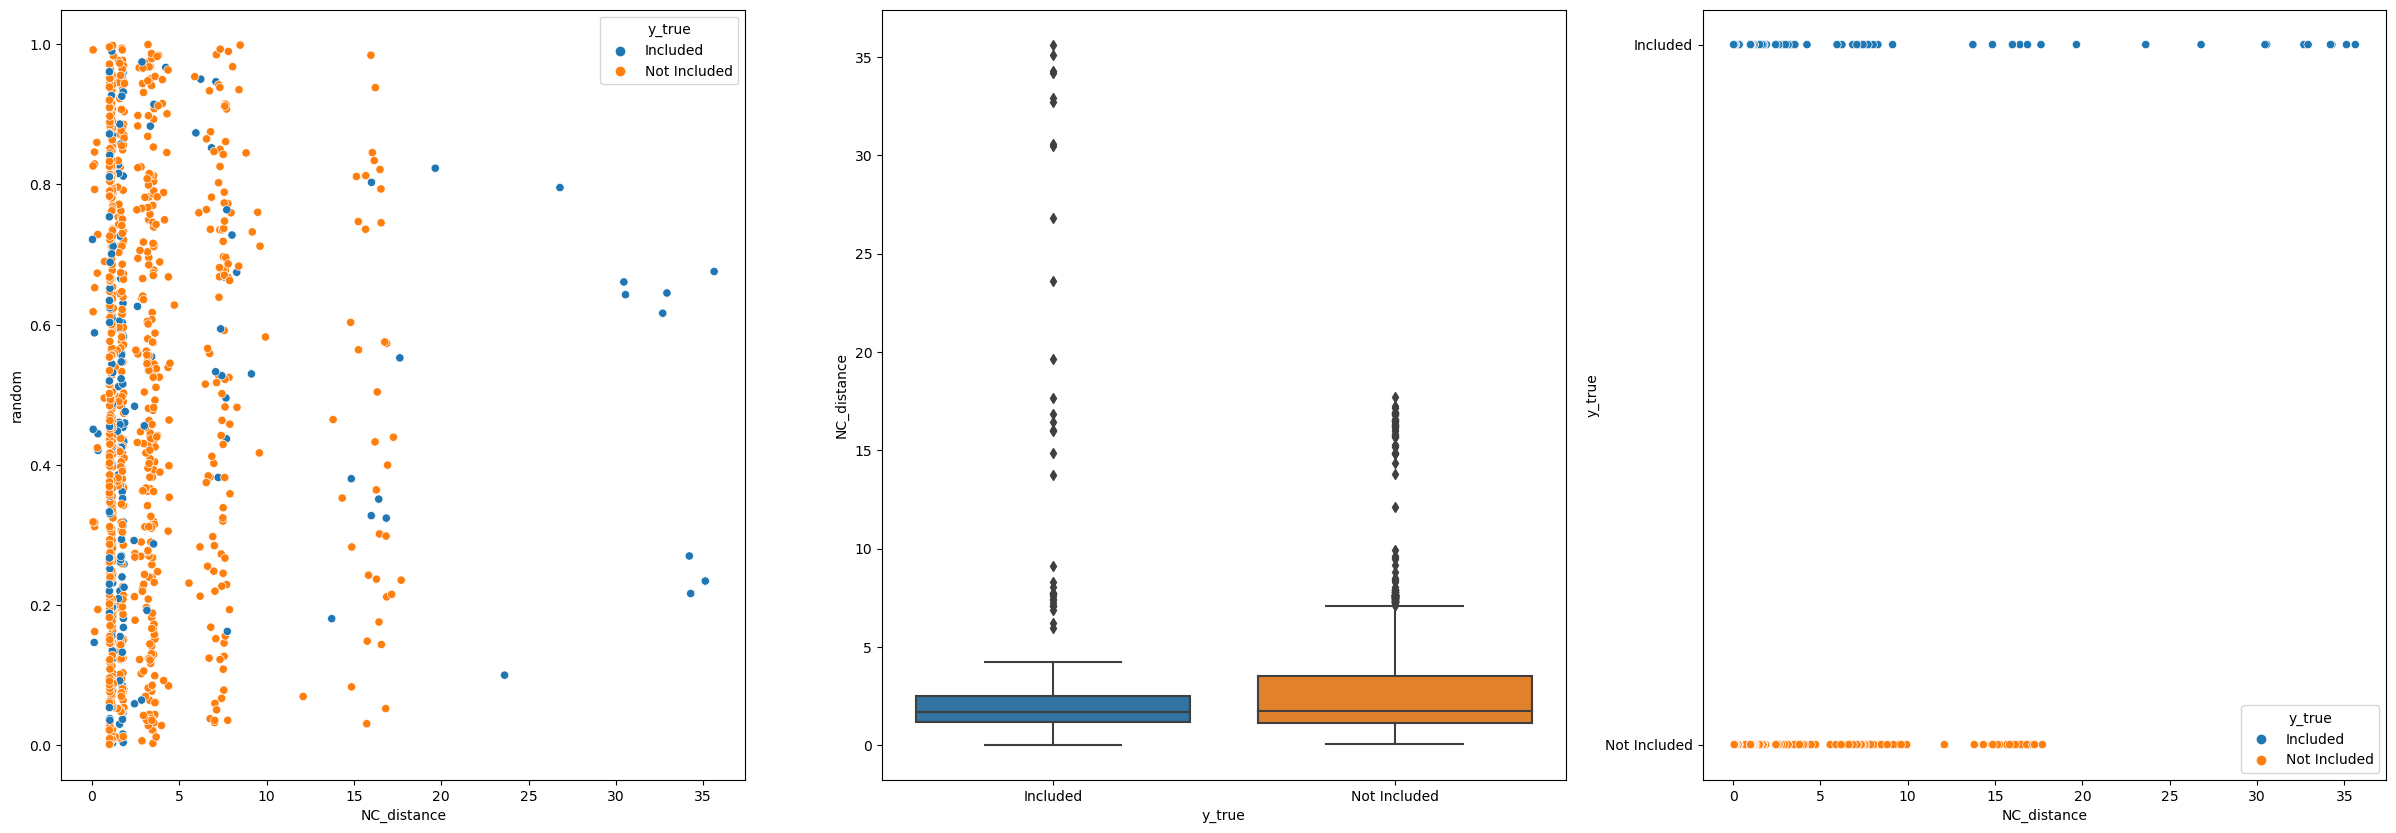

In [32]:
fig, ax = plt.subplots(1, 3, figsize = (30, 10))
sns.scatterplot(data = df, x = 'NC_distance', y = 'random', hue = 'y_true', ax = ax[0])
sns.boxplot(data = df, x = 'y_true', y = 'NC_distance', ax = ax[1])
sns.scatterplot(data = df, x = 'NC_distance', y = 'y_true', hue = 'y_true', ax = ax[2])
plt.show()

<AxesSubplot:xlabel='NC_distance', ylabel='C_distance'>

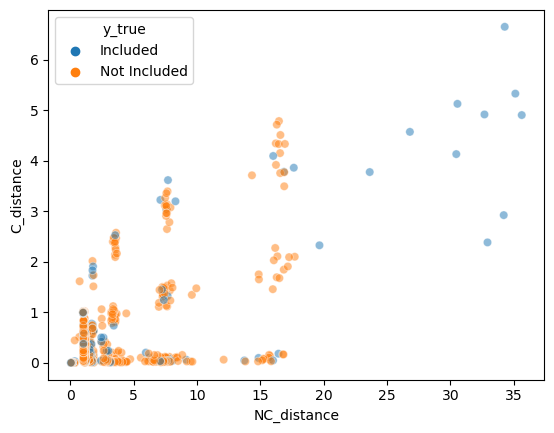

In [33]:
sns.scatterplot(data = df, x = 'NC_distance', y = 'C_distance', hue = 'y_true', alpha = .5)

In [34]:
df.loc[scanner.missing_pairs_decimal_repr,['C_distance','NC_distance']].describe()

,C_distance,NC_distance
count,24.000000,24.000000
mean,0.748179,0.767596
std,0.441270,0.416098
min,0.000000,0.031750
25%,0.736309,0.766975
50%,0.994968,1.000035
75%,0.999061,1.001495
max,1.011239,1.037574


In [35]:
df.loc[scanner.missing_pairs_decimal_repr,:]

,y_true,C_distance,NC_distance,random,missing
1000,Not Included,0.992920,1.000918,0.402774,True
1001,Not Included,1.003988,1.001479,0.356974,True
1002,Not Included,0.995734,1.002787,0.501774,True
1003,Not Included,1.003971,1.002258,0.832717,True
1004,Not Included,1.011239,1.001578,0.215184,True
1005,Not Included,1.005238,1.001497,0.938689,True
1006,Included,0.995163,1.000740,0.519740,True
1007,Included,1.001777,1.001495,0.220289,True
1008,Included,0.990670,1.000960,0.054025,True
1009,Included,0.994773,1.000575,0.230024,True


In [36]:
df.loc[df.C_distance.lt(1.05)*df.NC_distance.lt(1.05),['NC_distance','C_distance','y_true']].groupby('y_true').describe()

NC_distance                                                    \
                   count      mean       std       min       25%       50%   
y_true                                                                       
Included            32.0  0.856803  0.335867  0.031750  1.000431  1.002303   
Not Included       143.0  0.924572  0.267957  0.063002  1.002480  1.022663   

                                 C_distance                                \
                   75%       max      count      mean       std       min   
y_true                                                                      
Included      1.022854  1.040934       32.0  0.760263  0.397978  0.000000   
Not Included  1.028684  1.048197      143.0  0.653841  0.403238  0.000026   

                                                      
                   25%       50%       75%       max  
y_true                                                
Included      0.578972  0.994542  1.003971  1.021182  
Not Included  0.245886  0.990983  1.004024  1.021416

In this case, we set the threshold at the max of missing pairs. However, this won't be the good way of setting the threshold. To set the empirical threshold, let's compute robust covariance of the two distance and see what the outliers with low distance numbers.

In [37]:
from sklearn.covariance import MinCovDet, EllipticEnvelope
from scipy.stats import f, chi2
c = f.ppf
robust_cov = MinCovDet()
robust_cov.fit(df.loc[:, ['C_distance','NC_distance']])

# elliptic = EllipticEnvelope().fit(df.loc[:, ['C_distance','NC_distance']])

MinCovDet()

In [38]:
n = df.shape[0]
p = 2
df['outliers'] = (robust_cov.dist_ > (n-1)*p/(n-p)*f.ppf(.99, p, n-p))
# df['outliers'] = (elliptic.dist_ > (n-1)*p/(n-p)*f.ppf(.99, p, n-p))

df.outliers.mean()

0.365234375

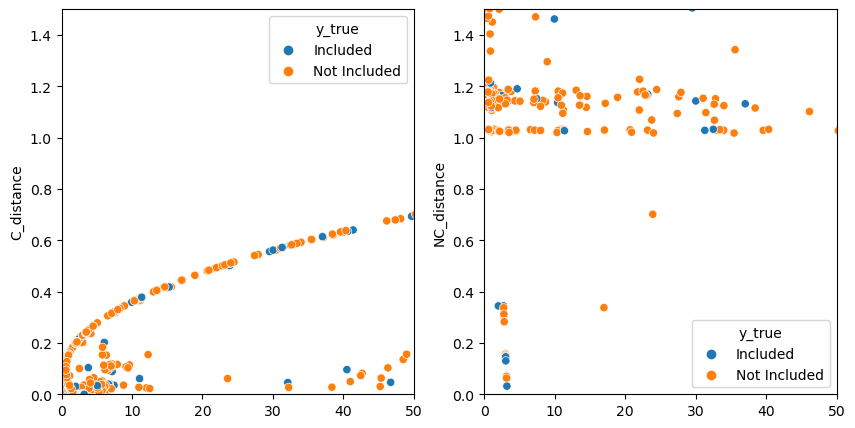

In [39]:
fig, ax = plt.subplots(1, 2, figsize = (10, 5))
sns.scatterplot(x = robust_cov.dist_, y= df.C_distance, hue = df.y_true, ax = ax[0])
sns.scatterplot(x = robust_cov.dist_, y= df.NC_distance, hue = df.y_true, ax = ax[1])

for i in range(2):
    ax[i].set_ylim(0,1.5)
    ax[i].set_xlim(0,50)
plt.show()

In [40]:
df.groupby('outliers')[['C_distance','NC_distance']].describe()

C_distance                                                    \
              count      mean       std       min       25%       50%   
outliers                                                                
False         650.0  0.073892  0.076036  0.000000  0.022890  0.043034   
True          374.0  1.262416  1.081833  0.022442  0.595011  1.000950   

                             NC_distance                                \
               75%       max       count      mean       std       min   
outliers                                                                 
False     0.099524  0.344397       650.0  2.572748  1.913224  0.031750   
True      1.344442  6.653113       374.0  5.001344  6.659544  0.337542   

                                                   
               25%       50%       75%        max  
outliers                                           
False     1.177622  1.742989  3.322062   8.487319  
True      1.027151  1.692068  7.436809  35.625866

In [41]:
df.groupby(['outliers', 'y_true'])[['y_true']].count()

y_true
outliers y_true              
False    Included         100
         Not Included     550
True     Included          75
         Not Included     299

In [42]:
df.groupby(['missing', 'outliers','y_true'])[['y_true']].count()

y_true
missing outliers y_true              
False   False    Included          98
                 Not Included     546
        True     Included          69
                 Not Included     287
True    False    Included           2
                 Not Included       4
        True     Included           6
                 Not Included      12

<AxesSubplot:xlabel='y_true', ylabel='NC_distance'>

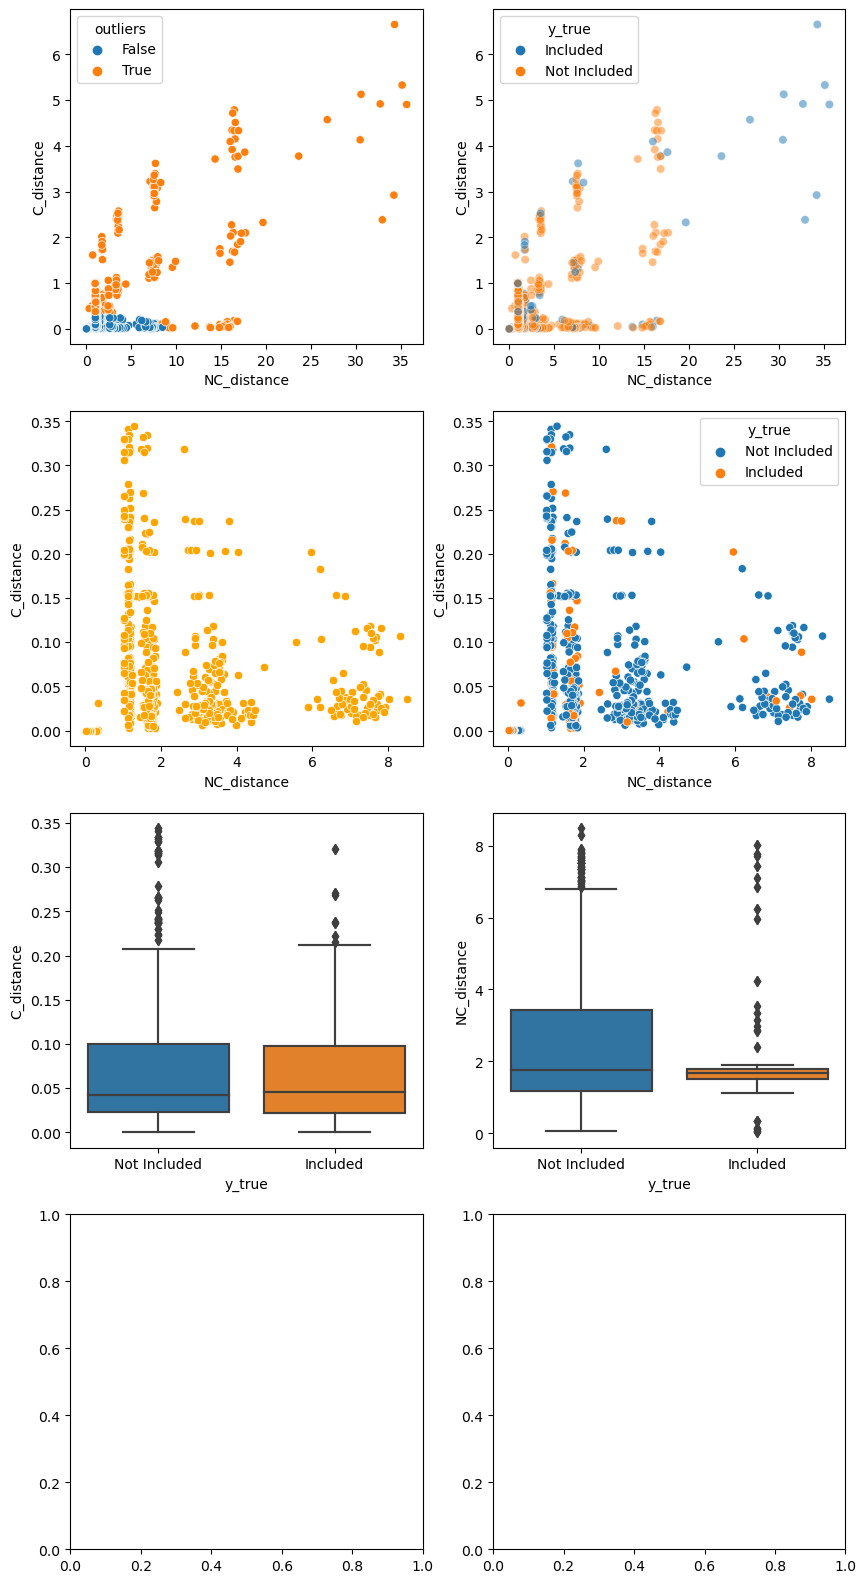

In [43]:
fig, ax = plt.subplots(4, 2, figsize = (10, 20))
sns.scatterplot(data = df, x = 'NC_distance', y= 'C_distance', hue = 'outliers', ax = ax[0, 0])
sns.scatterplot(data = df, x = 'NC_distance', y = 'C_distance', hue = 'y_true', alpha = .5, ax = ax[0, 1])
sns.scatterplot(data = df.loc[-df.outliers,:], x = 'NC_distance', y= 'C_distance', color = 'orange', ax = ax[1, 0])
sns.scatterplot(data = df.loc[-df.outliers,:], x = 'NC_distance', y = 'C_distance', hue = 'y_true', ax = ax[1, 1])
sns.boxplot(data = df.loc[-df.outliers,:], x = 'y_true', y = 'C_distance', ax = ax[2,0])
sns.boxplot(data = df.loc[-df.outliers,:], x = 'y_true', y = 'NC_distance', ax = ax[2,1])
sns.boxplot(data = df.loc[-df.outliers,:], x = 'y_true', y = 'C_distance', ax = ax[2,0])
sns.boxplot(data = df.loc[-df.outliers,:], x = 'y_true', y = 'NC_distance', ax = ax[2,1])